# 0) Amaç ve Deney Protokolü
- Aynı mimari (sigmoid.py vs hardsigmoid.py)
- Aynı dataset / augment / batch / epoch
- Aynı optimizer / lr / weight_decay
- Aynı seed
- Metrikler: train_loss, test_loss, acc
- Çıktı: epoch-epoch yan yana log + final özet tablo


# 1) Importlar


In [ ]:
import os, random, time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import sys

ROOT = r"pytorch-cnn-architecture-library\Torch_CNN\activation_functions\Egde\HardSigmoid"

if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

from models.sigmoid import build_model as build_sigmoid_model
from models.hardsigmoid import build_model as build_hardsigmoid_model

print("Imports OK ✅")

Imports OK ✅


# 2) Device / Mixed Precision (AMP)


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = True and (device == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

print("device:", device, "| amp:", use_amp)

device: cuda | amp: True


C:\Users\hdgn5\AppData\Local\Temp\ipykernel_10308\2082159042.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


 # 3) Seed / Reproducibility


In [13]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True   # hız
    torch.backends.cudnn.deterministic = False

seed = 42
seed_everything(seed)

# 4) Hyperparametreler


In [14]:
epochs = 15
batch_size = 128
lr = 3e-4
weight_decay = 5e-4
num_workers = 4
data_root = "./data"  

# 5) Dataset & DataLoader (CIFAR-10 öneri)


In [15]:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_set = datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_tf)
test_set  = datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True, drop_last=True)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=True)

num_classes = 10

Files already downloaded and verified
Files already downloaded and verified


# 6) Modelleri Oluştur (Aynı mimari, farklı gate)


In [16]:
model_sig = build_sigmoid_model(num_classes=num_classes).to(device)
model_hsig = build_hardsigmoid_model(num_classes=num_classes).to(device)

print("sigmoid params:", sum(p.numel() for p in model_sig.parameters()))
print("hardsig params:", sum(p.numel() for p in model_hsig.parameters()))

sigmoid params: 1340746
hardsig params: 1340746


# 7) Loss / Optimizer / Scheduler (ikisine aynı)


In [17]:
criterion = nn.CrossEntropyLoss()

opt_sig = torch.optim.AdamW(model_sig.parameters(), lr=lr, weight_decay=weight_decay)
opt_hsig = torch.optim.AdamW(model_hsig.parameters(), lr=lr, weight_decay=weight_decay)

# basit cosine örneği (istersen kapat)
sched_sig = torch.optim.lr_scheduler.CosineAnnealingLR(opt_sig, T_max=epochs)
sched_hsig = torch.optim.lr_scheduler.CosineAnnealingLR(opt_hsig, T_max=epochs)

# 8) Train / Eval Fonksiyonları


In [18]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


def train_one_epoch(model, optimizer, loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total

# 9) Eğitim Döngüsü (Epoch epoch yan yana log)


In [19]:
history = {
    "sigmoid": {"train_loss": [], "test_loss": [], "acc": []},
    "hardsigmoid": {"train_loss": [], "test_loss": [], "acc": []},
}

for ep in range(1, epochs+1):
    t0 = time.time()

    tr_loss_s, tr_acc_s = train_one_epoch(model_sig, opt_sig, train_loader)
    te_loss_s, te_acc_s = evaluate(model_sig, test_loader)

    tr_loss_h, tr_acc_h = train_one_epoch(model_hsig, opt_hsig, train_loader)
    te_loss_h, te_acc_h = evaluate(model_hsig, test_loader)

    sched_sig.step()
    sched_hsig.step()

    history["sigmoid"]["train_loss"].append(tr_loss_s)
    history["sigmoid"]["test_loss"].append(te_loss_s)
    history["sigmoid"]["acc"].append(te_acc_s)

    history["hardsigmoid"]["train_loss"].append(tr_loss_h)
    history["hardsigmoid"]["test_loss"].append(te_loss_h)
    history["hardsigmoid"]["acc"].append(te_acc_h)

    dt = time.time() - t0

    print(
        f"Epoch {ep:02d}/{epochs} | "
        f"Sigmoid:  train_loss={tr_loss_s:.4f} test_loss={te_loss_s:.4f} acc={te_acc_s:.4f} | "
        f"HardSig:  train_loss={tr_loss_h:.4f} test_loss={te_loss_h:.4f} acc={te_acc_h:.4f} | "
        f"time={dt:.1f}s"
    )

C:\Users\hdgn5\AppData\Local\Temp\ipykernel_10308\1609117490.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 01/15 | Sigmoid:  train_loss=1.7961 test_loss=1.4514 acc=0.4703 | HardSig:  train_loss=1.7799 test_loss=1.4688 acc=0.4553 | time=98.1s
Epoch 02/15 | Sigmoid:  train_loss=1.4926 test_loss=1.3405 acc=0.5116 | HardSig:  train_loss=1.4721 test_loss=1.2876 acc=0.5329 | time=95.8s
Epoch 03/15 | Sigmoid:  train_loss=1.3851 test_loss=1.2540 acc=0.5433 | HardSig:  train_loss=1.3405 test_loss=1.2085 acc=0.5638 | time=91.7s
Epoch 04/15 | Sigmoid:  train_loss=1.2935 test_loss=1.1495 acc=0.5897 | HardSig:  train_loss=1.2486 test_loss=1.1378 acc=0.5874 | time=90.3s
Epoch 05/15 | Sigmoid:  train_loss=1.2207 test_loss=1.0865 acc=0.6115 | HardSig:  train_loss=1.1686 test_loss=1.0444 acc=0.6215 | time=94.7s
Epoch 06/15 | Sigmoid:  train_loss=1.1563 test_loss=1.0365 acc=0.6287 | HardSig:  train_loss=1.1047 test_loss=1.0067 acc=0.6473 | time=95.7s
Epoch 07/15 | Sigmoid:  train_loss=1.1050 test_loss=0.9880 acc=0.6488 | HardSig:  train_loss=1.0519 test_loss=0.9769 acc=0.6529 | time=97.3s
Epoch 08/15 |

# 10) Sonuç Tablosu (Final + Peak)


In [20]:
def summarize(name):
    acc = np.array(history[name]["acc"])
    tl  = np.array(history[name]["test_loss"])
    return {
        "final_acc": float(acc[-1]),
        "peak_acc": float(acc.max()),
        "peak_epoch": int(acc.argmax() + 1),
        "final_test_loss": float(tl[-1]),
        "min_test_loss": float(tl.min()),
        "min_loss_epoch": int(tl.argmin() + 1),
    }

sum_s = summarize("sigmoid")
sum_h = summarize("hardsigmoid")

import pandas as pd
df = pd.DataFrame([sum_s, sum_h], index=["Sigmoid", "HardSigmoid"])
df


,final_acc,peak_acc,peak_epoch,final_test_loss,min_test_loss,min_loss_epoch
Sigmoid,0.6985,0.7001,13,0.856016,0.856016,15
HardSigmoid,0.7065,0.7065,15,0.836258,0.836258,15


# 11) Grafikler (Accuracy / Loss)


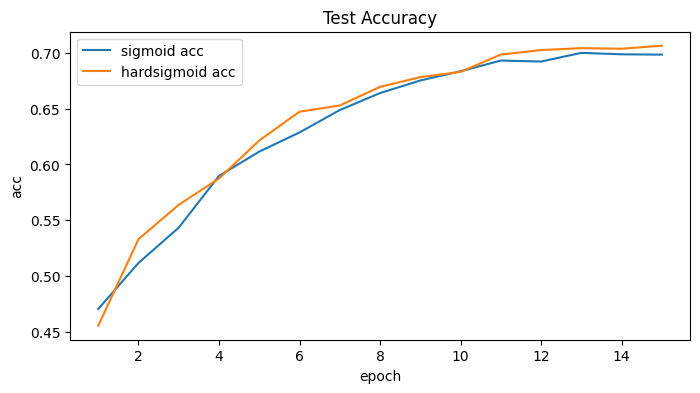

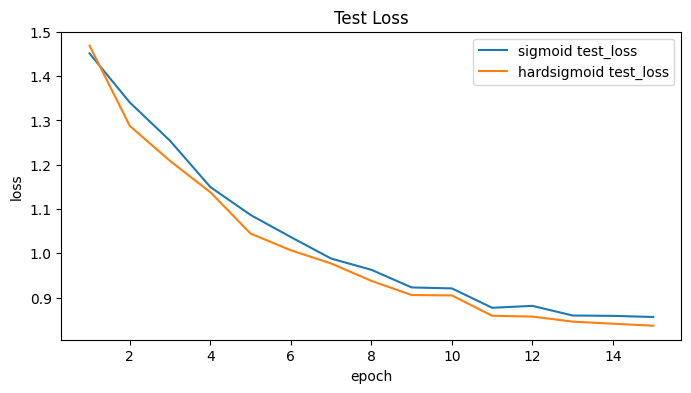

In [21]:
import matplotlib.pyplot as plt

epochs_axis = np.arange(1, epochs+1)

plt.figure(figsize=(8,4))
plt.plot(epochs_axis, history["sigmoid"]["acc"], label="sigmoid acc")
plt.plot(epochs_axis, history["hardsigmoid"]["acc"], label="hardsigmoid acc")
plt.xlabel("epoch"); plt.ylabel("acc"); plt.title("Test Accuracy")
plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs_axis, history["sigmoid"]["test_loss"], label="sigmoid test_loss")
plt.plot(epochs_axis, history["hardsigmoid"]["test_loss"], label="hardsigmoid test_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Test Loss")
plt.legend(); plt.show()
